In [ ]:
import os, sys
from pathlib import Path

ENV_IS_GOOGLE_COLAB = True if 'google.colab' in str(get_ipython()) else False
os.environ["ENV_IS_GOOGLE_COLAB"] = str(ENV_IS_GOOGLE_COLAB)

if ENV_IS_GOOGLE_COLAB:
  from google.colab import drive
  mountpoint = Path("/content/drive")
  drive.mount(str(mountpoint)) # Mount gdrive to BASE
  base = mountpoint / "MyDrive/SODUCO/article_das_2022" # Adapt this to your situation
  sys.path.append(str(base)) # Add BASE to Python Path
  BASE = Path(base).resolve() # Make BASE absolute
  DATASETS =  BASE / "dataset"
else:
  BASE = Path(os.path.dirname(os.path.realpath("__file__"))).resolve() # If not on GColab, BASE will be the directory of this notebook
  DATASETS = BASE.parent.parent / "dataset"

print(sys.path)
print(BASE)
print(DATASETS)

# 30 - Experiment 1: figures and tables

## Initialisation

In [1]:
""" RUN THIS BLOCK ONLY ON GOOGLE COLAB """

# `GDRIVE_PAPER_FOLDER` is the relative path in your GDrive to the folder
# contaning the code of the paper
# ADAPT TO YOUR SITUATION !
%env GDRIVE_PAPER_FOLDER=TEST

# Mount Google Drive to your Colab environment. May require to log in to Google.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Copy the Python modules in `PATH_TO_SOURCES/src/ner/util` to GColab
# to enable import.
!cp -r /content/drive/MyDrive/$GDRIVE_PAPER_FOLDER/src/ner/util .


env: GDRIVE_PAPER_FOLDER=TEST
Mounted at /content/drive


In [ ]:
""" Loads the configuration """

# Set to 1/true/ to set the logging level of nerlogger to DEBUG 
# and save the the spacy datasets as TXT along with the .spacy file
#  for easier debug of the training set generation.
%env DEBUG=1

# If True, activates a set of assertions in the notebooks to ensure
# that the scripts runs with the parameters used in the paper.
%env AS_IN_THE_PAPER = True

import util.config as config

config.show()


In [ ]:
from pathlib import Path
from util import config

# PATHS
METRICS_DIR = config.NERDIR / "20-experiment_1_metrics" # Or set the path to the metrics extracted from the release archive
METRICS_DIR

In [ ]:
import pandas as pd
import re
import os
import json

def compile_metrics(path): 
    rundirs = [f for f in os.listdir(path) if "run_" in f]

    df = pd.DataFrame()
    for run_dir in rundirs:
        run_path = path / run_dir
        nrun = re.search("\d+",run_dir)[0]
        
        files = [f for f in os.listdir(run_path) if "test_" in f]
        sizes = [int(re.search("\d+",f)[0]) for f in files]
        
        for file, size in zip(files,sizes):
            file_path = run_path / file
            dftmp = pd.read_json(file_path, typ='series')
            dftmp = pd.DataFrame([dftmp])
            
            dftmp["trainsize"] = size 
            dftmp["run"] = nrun
            dftmp["trainsize_p"] = round(100 * size / 6373, 1)
            df = pd.concat([df, dftmp])

    return df.groupby(["run","trainsize"]).first()

# Load SpaCy metrics from metrics jsons
spacy_ner = compile_metrics(METRICS_DIR / "21-spacy_ner")
# Align columns with BERT format
spacy_ner.rename(columns={"ents_p":"eval_precision", "ents_r":"eval_recall", "ents_f":"eval_f1"}, inplace=True)

# Load Camembert metrics from metrics jsons
camembert = compile_metrics(METRICS_DIR / "22-camembert")

# Load Camembert-pretrained metrics from metrics JSONS
camembert_pretrained = compile_metrics(METRICS_DIR / "23-camembert_pretrained")

# Create the full table
metrics_raw = pd.concat([spacy_ner, camembert, camembert_pretrained], keys=["spacy_ner","camembert", "camembert_pretrained"])
metrics_raw

# Build the averaged table


In [ ]:
# Store p/r/f1 as percentages
eval_ = ["eval_f1","eval_precision","eval_recall"]
metrics = metrics_raw.copy()
metrics[eval_] = metrics_raw[eval_].multiply(100., axis=1)
metrics.head()

In [ ]:
# Average over runs
averaged = metrics.groupby(level=0).apply(lambda grp: grp.groupby(by="trainsize").mean())
averaged.set_index(["trainsize_p"], append=True,inplace=True)

# Keep just the necessary columns
averaged=averaged[["eval_precision","eval_recall","eval_f1"]]

# Set pretty names
averaged.index.names = ['Model','Trainset Size',"%"]
averaged.rename(columns={"eval_precision": "Precision", "eval_recall": "Recall", "eval_f1":"F1 score"}, errors="raise", inplace=True)
averaged.rename(mapper={"camembert": "CmBERT","camembert_pretrained":"CmBERT+ptrn","spacy_ner":"SpaCy NER"}, errors="ignore", inplace=True, axis=0)
averaged

# Create the results table
Title: "Experimental results of the NER models performances when trained on varying numbers of examples"

In [ ]:
# Filter and transpose to obtain the latex table
latex_table = averaged.stack().unstack(level=[1,2])

# Swap model name and metrics to get a nice table
latex_table = latex_table.swaplevel(0,1).sort_index(level=0)

caption = "F1 score, precision and recall measured on the fine-tuned models CmBERT, CmBERT+ptrn and SpaCy NER in experiment 1 for 8 training sets of increasing sizes."
print(latex_table.to_latex(float_format="%.1f", multirow=True, caption=caption))
latex_table

# Create the graphs

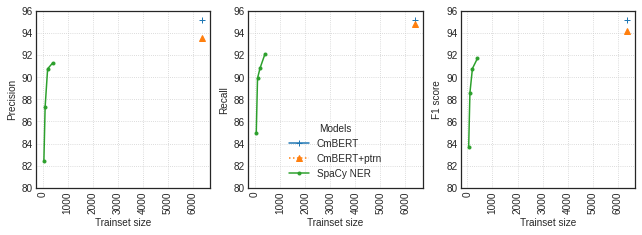

In [13]:
import matplotlib.pyplot as plt


averaged = metrics.groupby(level=0).apply(lambda grp: grp.groupby(by="trainsize").mean())
averaged.rename(columns={"eval_precision": "Precision", "eval_recall": "Recall", "eval_f1":"F1 score"}, errors="raise", inplace=True)
averaged.rename(mapper={"camembert": "CmBERT","camembert_pretrained":"CmBERT+ptrn","spacy_ner":"SpaCy NER"}, errors="ignore", inplace=True, axis=0)


# Keep just the necessary columns
averaged=averaged[["Precision","Recall","F1 score"]]
prec = averaged["Precision"].unstack().T
recall = averaged["Recall"].unstack().T
f1 = averaged["F1 score"].unstack().T

plt.style.use('seaborn-white')  # Nicer plots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex='row', figsize=(9, 3))
fig.tight_layout()


# plot subplots
ls=['+-','^:','.-']
ax1 = prec.plot(ax=axes[0], xlabel="Trainset size", ylabel="Precision", legend=False, style=ls)
ax2 = recall.plot(ax=axes[1], xlabel="Trainset size",ylabel="Recall", legend=False, style=ls)
ax3 = f1.plot(ax=axes[2], xlabel="Trainset size",ylabel="F1 score", legend=False, style=ls)

import numpy as np
plt.xticks(np.arange(0,6400,1000))

plt.setp( ax1.xaxis.get_majorticklabels(), rotation=90 )
plt.setp( ax2.xaxis.get_majorticklabels(), rotation=90 )
plt.setp( ax3.xaxis.get_majorticklabels(), rotation=90 )

# Align y ticks
ax1.set_yticks(ax1.get_yticks())
ax2.set_yticks(ax1.get_yticks())
ax3.set_yticks(ax1.get_yticks())

                           
# Set shared legend above the plots
ax2.legend(loc="lower center",   # Position of legend
           title="Models",  # Title for the legend
           bbox_to_anchor=(0.5, 0)
           )

ax1.grid(linestyle='dotted')
ax2.grid(linestyle='dotted')
ax3.grid(linestyle='dotted')

plt.savefig('experiment-1-models-performances.pdf', dpi=300, format='pdf',bbox_inches='tight')